In [104]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import re
import dateutil.parser as dparser
from tqdm.notebook import tqdm
import tiktoken
import openai
import os
import time
import matplotlib.pyplot as plt
from collections import Counter
from datetime import datetime
import tkinter as tk
from tkinter import messagebox
from dotenv import load_dotenv
load_dotenv()

True

In [57]:
OPENAI_KEY = os.getenv('OPENAI_KEY')
openai.api_key = OPENAI_KEY

In [58]:
def find_max_len(df: pd.DataFrame):
    '''
    Find the longest text entry in a dataset

    :param df: dataframe
    :return: max length
    '''
    max_len = 0
    for text in df['text']:
        if len(text) > max_len:
            max_len = len(text)
    return max_len

## Dataframes

In [59]:
df_nine_for_news = pd.read_csv('nine_for_news_clean.csv').drop(['index'], axis=1).dropna()
df_nine_for_news['source'] = 'Nine for News'

# Filter all non-article entries
df_nine_for_news = df_nine_for_news[df_nine_for_news['url'].str.contains("2008|2009|2010|2011|2012|2013|2014|2015|2016|2017|2018|2019|2020|2021|2022|2023|tag|categorie|page")==False]


df_nine_for_news

,text,date,url,source
0,\n\nNet Binnen\nSwitch skinSidebarWillekeurig ...,28-05-2023,https://www.ninefornews.nl/felle-kritiek-op-fe...,Nine for News
1,\n\nNet Binnen\nSwitch skinSidebarWillekeurig ...,28-05-2023,https://www.ninefornews.nl/bijwerkingencentrum...,Nine for News
2,\n\nNet Binnen\nSwitch skinSidebarWillekeurig ...,28-05-2023,https://www.ninefornews.nl/internet-ontploft-n...,Nine for News
3,\n\nNet Binnen\nSwitch skinSidebarWillekeurig ...,28-05-2023,https://www.ninefornews.nl/ggd-baas-heeft-spij...,Nine for News
4,\n\nNet Binnen\nSwitch skinSidebarWillekeurig ...,27-05-2023,https://www.ninefornews.nl/kijk-europarlementa...,Nine for News
...,...,...,...,...
1356,\n\nNet Binnen\nSwitch skinSidebarWillekeurig ...,18-10-2019,https://www.ninefornews.nl/stad-vandaan-kom-br...,Nine for News
1357,\n\nNet Binnen\nSwitch skinSidebarWillekeurig ...,8-10-2019,https://www.ninefornews.nl/tientallen-ufos-wit...,Nine for News
1358,\n\nNet Binnen\nSwitch skinSidebarWillekeurig ...,7-10-2019,https://www.ninefornews.nl/groot-boeing-737-ge...,Nine for News
1359,\n\nNet Binnen\nSwitch skinSidebarWillekeurig ...,5-10-2019,https://www.ninefornews.nl/vloot-vreemde-objec...,Nine for News


In [60]:
df_indymedia= pd.read_csv('indymedia_clean.csv').drop(['Unnamed: 0', 'index'], axis=1).dropna()
df_indymedia['source'] = 'Indy media'

# Filter all non-article entries
df_indymedia = df_indymedia[df_indymedia['url'].str.contains("node")==True]
df_indymedia

,text,date,url,source
0,IndyMedia\n\n\n\n\n\n\n\n\n\nSteun Indymedia N...,18-5-2023,https://www.indymedia.nl/node/53408,Indy media
1,IndyMedia\n\n\n\n\n\n\n\n\n\nSteun Indymedia N...,16-5-2023,https://www.indymedia.nl/node/53390,Indy media
2,IndyMedia\n\n\n\n\n\n\n\n\n\nSteun Indymedia N...,5-11-2023,https://www.indymedia.nl/node/53372,Indy media
3,IndyMedia\n\n\n\n\n\n\n\n\n\nSteun Indymedia N...,5-6-2023,https://www.indymedia.nl/node/53366,Indy media
4,IndyMedia\n\n\n\n\n\n\n\n\n\nSteun Indymedia N...,5-3-2023,https://www.indymedia.nl/node/53348,Indy media
...,...,...,...,...
57,IndyMedia\n\n\n\n\n\n\n\n\n\nSteun Indymedia N...,5-10-2023,https://www.indymedia.nl/node/53371,Indy media
58,IndyMedia\n\n\n\n\n\n\n\n\n\nSteun Indymedia N...,20-5-2023,https://www.indymedia.nl/node/53419,Indy media
59,IndyMedia\n\n\n\n\n\n\n\n\n\nSteun Indymedia N...,16-5-2023,https://www.indymedia.nl/node/add/comment/5339...,Indy media
60,IndyMedia\n\n\n\n\n\n\n\n\n\nSteun Indymedia N...,16-5-2023,https://www.indymedia.nl/node/53395,Indy media


In [61]:
df_niburu = pd.read_csv('niburu_clean.csv').drop(['Unnamed: 0', 'index'], axis=1).dropna()
df_niburu['source'] = 'Niburu'

# Filter all non-article entries
df_niburu = df_niburu[df_niburu['url'].str.contains("start")==False]
df_niburu

,text,date,url,source
0,Toggle navigationInfo Nog steeds is het groots...,28-5-2023,https://niburu.co/,Niburu
1,Toggle navigationInfo Nog steeds is het groots...,28-5-2023,https://niburu.co/het-complot/18598-het-absurd...,Niburu
2,Toggle navigationInfo Je hebt in ons land twee...,28-5-2023,https://niburu.co/het-complot/18597-politie-bo...,Niburu
3,Toggle navigationInfo We vergeten snel en dat ...,28-5-2023,https://niburu.co/het-complot/18592-dit-is-hoe...,Niburu
4,Toggle navigationInfoHet heeft er alle schijn ...,27-5-2023,https://niburu.co/binnenland/18595-er-lijkt-ie...,Niburu
...,...,...,...,...
239,Toggle navigationInfo Op het moment dat kinder...,9-4-2023,https://niburu.co/het-complot/18448-scholen-wo...,Niburu
240,Toggle navigationInfo In de alternatieve werel...,8-4-2023,https://niburu.co/buitenland/18444-wordt-rober...,Niburu
241,Toggle navigationInfo Over het algemeen heeft ...,8-4-2023,https://niburu.co/buitenland/18446-het-ziet-er...,Niburu
242,Toggle navigationInfo Al jarenlang waarschuwen...,8-4-2023,https://niburu.co/het-complot/18445-nog-veel-m...,Niburu


In [63]:
df_frontnieuws = pd.read_csv('frontnieuws_clean.csv').drop(['Unnamed: 0', 'index'], axis=1).dropna()
df_frontnieuws['source'] = 'Frontnieuws'

# Filter all non-article entries
df_frontnieuws= df_frontnieuws[df_frontnieuws['url'].str.contains("category|#comments|#respond|email-protection")==False]
df_frontnieuws

,text,date,url,source
1,\n\n\n\nWelcome!ZoekFrontnieuws\n\n\n\nCOVID-1...,28-5-2023,https://www.frontnieuws.com/covid-19-cartoons/,Frontnieuws
7,\n\n\n\nWelcome!ZoekFrontnieuws\n\n\n\n - - A...,28-5-2023,https://www.frontnieuws.com/,Frontnieuws
8,\n\n\n\nWelcome!ZoekFrontnieuws\n\n\n\n529KMaa...,28-5-2023,https://www.frontnieuws.com/de-anti-antisemiti...,Frontnieuws
9,\n\n\n\nWelcome!ZoekFrontnieuws\n\n\n\nFrontni...,28-5-2023,https://www.frontnieuws.com/author/frontnieuws...,Frontnieuws
10,\n\n\n\nWelcome!ZoekFrontnieuws\n\n\n\n768WAls...,28-5-2023,https://www.frontnieuws.com/is-oekraine-babe-r...,Frontnieuws
...,...,...,...,...
628,\n\n\n\nWelcome!ZoekFrontnieuws\n\n\n\n1745Jam...,5-11-2020,https://www.frontnieuws.com/verkiezingsfraude-...,Frontnieuws
630,\n\n\n\nWelcome!ZoekFrontnieuws\n\n\n\n1847()H...,26-1-2021,https://www.frontnieuws.com/pfizer-covid-19-va...,Frontnieuws
632,\n\n\n\nWelcome!ZoekFrontnieuws\n\n\n\n938CC B...,13-7-2020,https://www.frontnieuws.com/servische-soldaten...,Frontnieuws
634,\n\n\n\nWelcome!ZoekFrontnieuws\n\n\n\nDe beëd...,7-10-2021,https://www.frontnieuws.com/luchtmacht-arts-vs...,Frontnieuws


# Full dataset

In [64]:
frames = [df_nine_for_news, df_indymedia, df_niburu, df_frontnieuws]
final_df = pd.concat(frames, ignore_index=True)
final_df

,text,date,url,source
0,\n\nNet Binnen\nSwitch skinSidebarWillekeurig ...,28-05-2023,https://www.ninefornews.nl/felle-kritiek-op-fe...,Nine for News
1,\n\nNet Binnen\nSwitch skinSidebarWillekeurig ...,28-05-2023,https://www.ninefornews.nl/bijwerkingencentrum...,Nine for News
2,\n\nNet Binnen\nSwitch skinSidebarWillekeurig ...,28-05-2023,https://www.ninefornews.nl/internet-ontploft-n...,Nine for News
3,\n\nNet Binnen\nSwitch skinSidebarWillekeurig ...,28-05-2023,https://www.ninefornews.nl/ggd-baas-heeft-spij...,Nine for News
4,\n\nNet Binnen\nSwitch skinSidebarWillekeurig ...,27-05-2023,https://www.ninefornews.nl/kijk-europarlementa...,Nine for News
...,...,...,...,...
1532,\n\n\n\nWelcome!ZoekFrontnieuws\n\n\n\n1745Jam...,5-11-2020,https://www.frontnieuws.com/verkiezingsfraude-...,Frontnieuws
1533,\n\n\n\nWelcome!ZoekFrontnieuws\n\n\n\n1847()H...,26-1-2021,https://www.frontnieuws.com/pfizer-covid-19-va...,Frontnieuws
1534,\n\n\n\nWelcome!ZoekFrontnieuws\n\n\n\n938CC B...,13-7-2020,https://www.frontnieuws.com/servische-soldaten...,Frontnieuws
1535,\n\n\n\nWelcome!ZoekFrontnieuws\n\n\n\nDe beëd...,7-10-2021,https://www.frontnieuws.com/luchtmacht-arts-vs...,Frontnieuws


# GPT
## Tokenizing

In [65]:
def tokenize_text(df):
    '''
    Uses tiktoken to create a gpt 3.5 turbo word embedding of the text

    :param df: dataframe
    :return: the dataframe with a new column containing the word embedding vector
    '''
    for i, row in enumerate(df['text']):
        text = str(row)
        tokenizer = tiktoken.encoding_for_model('gpt-3.5-turbo')
        encoded_text = tokenizer.encode(text)

        # Max amount of tokens for a request is a little more than 4000
        # this includes both the text and the instructions given to GPT
        # Lets remove the texts > 3000 tokens
        if len(encoded_text) > 3000:
            encoded_text = pd.NA

        df['encoded text'][i] = encoded_text

    return df

In [66]:
final_df['encoded text'] = ''
final_df = tokenize_text(final_df)

# Checking how many rows have a token count>3000
too_much_tokens = final_df['encoded text'].isna().sum()
print(f'Number of row > 3000 tokens: {too_much_tokens}')

# Dropping them
final_df = final_df.dropna()
final_df

Number of row > 3000 tokens: 163


,text,date,url,source,encoded text
0,\n\nNet Binnen\nSwitch skinSidebarWillekeurig ...,28-05-2023,https://www.ninefornews.nl/felle-kritiek-op-fe...,Nine for News,"[271, 7099, 426, 35811, 198, 17259, 6930, 4817..."
1,\n\nNet Binnen\nSwitch skinSidebarWillekeurig ...,28-05-2023,https://www.ninefornews.nl/bijwerkingencentrum...,Nine for News,"[271, 7099, 426, 35811, 198, 17259, 6930, 4817..."
2,\n\nNet Binnen\nSwitch skinSidebarWillekeurig ...,28-05-2023,https://www.ninefornews.nl/internet-ontploft-n...,Nine for News,"[271, 7099, 426, 35811, 198, 17259, 6930, 4817..."
3,\n\nNet Binnen\nSwitch skinSidebarWillekeurig ...,28-05-2023,https://www.ninefornews.nl/ggd-baas-heeft-spij...,Nine for News,"[271, 7099, 426, 35811, 198, 17259, 6930, 4817..."
4,\n\nNet Binnen\nSwitch skinSidebarWillekeurig ...,27-05-2023,https://www.ninefornews.nl/kijk-europarlementa...,Nine for News,"[271, 7099, 426, 35811, 198, 17259, 6930, 4817..."
...,...,...,...,...,...
1528,\n\n\n\nWelcome!ZoekFrontnieuws\n\n\n\n2036HHe...,5-2-2023,https://www.frontnieuws.com/brits-leger-zou-in...,Frontnieuws,"[1038, 14262, 0, 57, 78, 1247, 24284, 11044, 8..."
1531,\n\n\n\nWelcome!ZoekFrontnieuws\n\n\n\n2562LVa...,27-5-2023,https://www.frontnieuws.com/oekrainse-claim-ov...,Frontnieuws,"[1038, 14262, 0, 57, 78, 1247, 24284, 11044, 8..."
1532,\n\n\n\nWelcome!ZoekFrontnieuws\n\n\n\n1745Jam...,5-11-2020,https://www.frontnieuws.com/verkiezingsfraude-...,Frontnieuws,"[1038, 14262, 0, 57, 78, 1247, 24284, 11044, 8..."
1533,\n\n\n\nWelcome!ZoekFrontnieuws\n\n\n\n1847()H...,26-1-2021,https://www.frontnieuws.com/pfizer-covid-19-va...,Frontnieuws,"[1038, 14262, 0, 57, 78, 1247, 24284, 11044, 8..."


In [67]:
def count_tokens_and_cost(df, role_prompt):
    '''
    Gives the total amount of tokens currently in the dataframe and calculates (or rather estimates) the price of the GPT request

    :param df: dataframe containing the embedded text in a column 'encoded text'
    :param role_prompt: The role prompt that is given with each GPT call
    :return: Print of amount of tokens and the cost
    '''
    # Counting the amount of tokens for the role prompt
    tokenizer = tiktoken.encoding_for_model('gpt-3.5-turbo')
    encoded_text = tokenizer.encode(role_prompt)

    count = 0
    for i in df['encoded text']:
        # Adding the role prompt as well since it is given with each row in the dataset
        count += len(i) + len(encoded_text)
    cost = (count/1000)*0.002
    return print(f'Amount of tokens = {count}, Price = {cost}$')

In [68]:
role_prompt = 'Je bent een robot die teksten analyseerd. Je antwoorden moeten in het Nederlands zijn. Haal de belangrijkste genoemde entiteiten en besproken onderwerpen uit de tekst. Kies maximaal 10 entiteiten en onderwerpen. Zet bij elk onderwerp en elke entiteit erbij of er positief of negatief over gepraat wordt in de tekst. Het is belangrijk dat je het sentiment van de auteur correct weergeeft. Geef antwoord als in het voorbeeld, dit is een Python dictionary: \n {entiteiten:{entiteit:sentiment}, onderwerpen:{onderwerp:sentiment}} De tekst: '

count_tokens_and_cost(final_df, role_prompt)

Amount of tokens = 2240027, Price = 4.480054$


# GPT request
# DO NOT RE-RUN!!!!

In [16]:
def get_entities_and_subjects_gpt(text):
    '''
    This contains the prompt to GPT

    :param text: A input text i.e. the raw text file of the final_df
    :return: GPT's response
    '''
    messages = []
    messages.append({"role":"system", "content":'Je bent een robot die teksten analyseerd. Je antwoorden moeten in het Nederlands zijn.' })
    messages.append({"role": "user", "content": 'Haal de belangrijkste genoemde entiteiten en besproken onderwerpen uit de tekst. Kies maximaal 10 entiteiten en onderwerpen. Zet bij elk onderwerp en elke entiteit erbij of er positief of negatief over gepraat wordt in de tekst. Het is belangrijk dat je het sentiment van de auteur correct weergeeft. Geef antwoord als in het voorbeeld, dit is een Python dictionary: {entiteiten:{entiteit:sentiment}, onderwerpen:{onderwerp:sentiment}}'})
    messages.append({"role":"user", "content":f'De tekst: {text}'})
    response = openai.ChatCompletion.create(
        model='gpt-3.5-turbo',
        messages=messages
    )
    messages = []
    gpt_result = response.choices[0].message['content']

    return gpt_result

In [17]:
final_df['GPT output'] = ''

In [18]:
final_df

,text,date,url,source,encoded text,GPT output
0,\n\nNet Binnen\nSwitch skinSidebarWillekeurig ...,28-05-2023,https://www.ninefornews.nl/felle-kritiek-op-fe...,Nine for News,"[271, 7099, 426, 35811, 198, 17259, 6930, 4817...",
1,\n\nNet Binnen\nSwitch skinSidebarWillekeurig ...,28-05-2023,https://www.ninefornews.nl/bijwerkingencentrum...,Nine for News,"[271, 7099, 426, 35811, 198, 17259, 6930, 4817...",
2,\n\nNet Binnen\nSwitch skinSidebarWillekeurig ...,28-05-2023,https://www.ninefornews.nl/internet-ontploft-n...,Nine for News,"[271, 7099, 426, 35811, 198, 17259, 6930, 4817...",
3,\n\nNet Binnen\nSwitch skinSidebarWillekeurig ...,28-05-2023,https://www.ninefornews.nl/ggd-baas-heeft-spij...,Nine for News,"[271, 7099, 426, 35811, 198, 17259, 6930, 4817...",
4,\n\nNet Binnen\nSwitch skinSidebarWillekeurig ...,27-05-2023,https://www.ninefornews.nl/kijk-europarlementa...,Nine for News,"[271, 7099, 426, 35811, 198, 17259, 6930, 4817...",
...,...,...,...,...,...,...
1528,\n\n\n\nWelcome!ZoekFrontnieuws\n\n\n\n2036HHe...,5-2-2023,https://www.frontnieuws.com/brits-leger-zou-in...,Frontnieuws,"[1038, 14262, 0, 57, 78, 1247, 24284, 11044, 8...",
1531,\n\n\n\nWelcome!ZoekFrontnieuws\n\n\n\n2562LVa...,27-5-2023,https://www.frontnieuws.com/oekrainse-claim-ov...,Frontnieuws,"[1038, 14262, 0, 57, 78, 1247, 24284, 11044, 8...",
1532,\n\n\n\nWelcome!ZoekFrontnieuws\n\n\n\n1745Jam...,5-11-2020,https://www.frontnieuws.com/verkiezingsfraude-...,Frontnieuws,"[1038, 14262, 0, 57, 78, 1247, 24284, 11044, 8...",
1533,\n\n\n\nWelcome!ZoekFrontnieuws\n\n\n\n1847()H...,26-1-2021,https://www.frontnieuws.com/pfizer-covid-19-va...,Frontnieuws,"[1038, 14262, 0, 57, 78, 1247, 24284, 11044, 8...",


In [19]:
def run_gpt_analysis(df):
    '''
    Sends requests to the openai's GPT api.

    :param df: the final dataframe
    :return: Nothing, but saves a csv of the dataframe containing GPT's response
    '''
    for index, text in enumerate(tqdm(df['text'])):
        # Do a few attempts per request
        for attempt in range(4):
            try:
                result = get_entities_and_subjects_gpt(text)
                df['GPT output'][index] = result
                print(f'Row {index} is done!')
                break
            except:
                # Sleep for 16 sec as the limit for trail accounts is 3 requests per minute
                print(f'Sleeping 16 sec at attempt {attempt} for row {index}.')
                time.sleep(16)
        df.to_csv('Final_results.csv')

In [21]:
# commented out just to be sure
#run_gpt_analysis(final_df)

  0%|          | 0/1374 [00:00<?, ?it/s]

Row 0 is done!
Row 1 is done!
Row 2 is done!
Row 3 is done!
Sleeping 16 sec at attempt 0 for row 4.
Row 4 is done!
Row 5 is done!
Sleeping 16 sec at attempt 0 for row 6.
Row 6 is done!
Sleeping 16 sec at attempt 0 for row 7.
Row 7 is done!
Sleeping 16 sec at attempt 0 for row 8.
Row 8 is done!
Sleeping 16 sec at attempt 0 for row 9.
Row 9 is done!
Sleeping 16 sec at attempt 0 for row 10.
Row 10 is done!
Sleeping 16 sec at attempt 0 for row 11.
Row 11 is done!
Row 12 is done!
Sleeping 16 sec at attempt 0 for row 13.
Row 13 is done!
Sleeping 16 sec at attempt 0 for row 14.
Row 14 is done!
Sleeping 16 sec at attempt 0 for row 15.
Row 15 is done!
Row 16 is done!
Sleeping 16 sec at attempt 0 for row 17.
Row 17 is done!
Sleeping 16 sec at attempt 0 for row 18.
Row 18 is done!
Sleeping 16 sec at attempt 0 for row 19.
Row 19 is done!
Sleeping 16 sec at attempt 0 for row 20.
Row 20 is done!
Row 21 is done!
Sleeping 16 sec at attempt 0 for row 22.
Row 22 is done!
Row 23 is done!
Sleeping 16 sec 

The code above fully ran. Unfortunately, due to the $5 trial account spending limit we were only able to send 1319 requests to GPT.
Since Frontnieuws was the last source added to the dataframe we don't have a lot of results for this source.

# Data Analysis

Starting out by cleaning the GPT data output. GPT's output was rather noisy. In hindsight we should have specified more, and stricter, json examples.
In the code below we go through the process of adding double quotation marks around each word ST the dictionary string can be turned into a dictionary by json.loads()


In [93]:
import json
df = pd.read_csv('Final_results.csv').drop('Unnamed: 0', axis=1).dropna()

# Counting number of rows failed to convert
count = 0

for index, entry in enumerate(df['GPT output']):

    # Removing certain character combinations
    entry = entry.replace("   ", "").replace("\n", "").replace("'", '').replace('"', "").replace('_', '')

    # Adding spaces around special characters
    entry = ''.join((' {} '.format(char) if char in ['{', '}', ':', ',', ' '] else char for char in entry))

    # Splitting words and adding double quotes in order to have the data readable by json
    entry_list = entry.split(' ')
    entry_list = ''.join(('"{}"'.format(word) if word not in ['{', '}', ':', ',', ' ', "'", "''", '""'] else word for word in entry_list))
    entry_list = entry_list.replace('""', '')

    # Try to make a json dict
    try:
        entry_list = json.loads(entry_list)
        df['GPT output'][index] = entry_list

    # Count how many failed
    except:
        count += 1

    # Remove all non dicts
    if isinstance(df['GPT output'][index], str):
        df.drop(index, inplace=True)

df = df.reset_index()
print(f'Could not convert {count} rows to dict')
print('total dataset lenght:', len(df['GPT output']))
print('All GPT entries are dicts:', all(isinstance(df['GPT output'][i], dict) for i, _ in enumerate(df['GPT output'])))

Could not convert 114 rows to dict
total dataset lenght: 1121
All GPT entries are dicts: True


In [94]:
# Converting the time strings to date time
for index, time_string in enumerate(df['date']):
    df['date'][index] = datetime.strptime(time_string, '%d-%m-%Y').date()

Saving the final fully cleaned DF containing the cleaned GPT output

In [46]:
df.to_csv('Final_GPT_data_cleaned.csv', index=False)

Creating some count dictionaries for entities and subjects

In [17]:
def get_count_dicts(df):
    '''
    Gets the count for each entity and subject and puts it in a dict
    :param df: the final df
    :return: 2 count dicts
    '''
    entity_list = []
    topic_list = []
    for index, _ in enumerate(df['GPT output']):
        for entity in df['GPT output'][index].get('entiteiten').keys():
            entity_list.append(entity)

        # Sometimes GPT did not give any subjects back
        if df['GPT output'][index].get('onderwerpen') is not None:
            for subject in df['GPT output'][index].get('onderwerpen').keys():
                topic_list.append(subject)

    entity_count = Counter(entity_list)
    topic_count = Counter(topic_list)
    return entity_count, topic_count

entity_count_dict = get_count_dicts(df)[0]
subject_count_dict = get_count_dicts(df)[1]

## Plotting the data

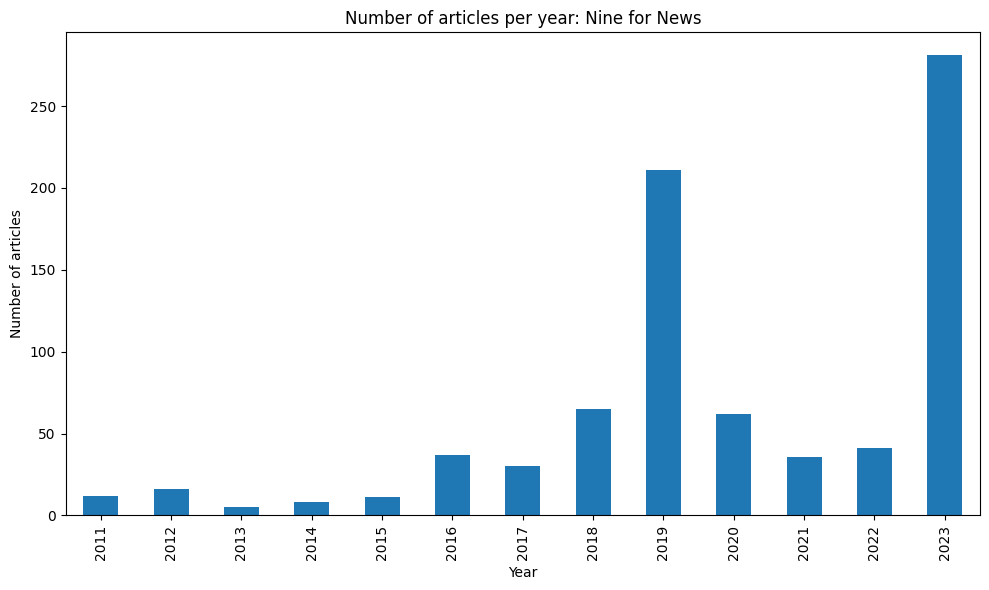

In [6]:
def plot_articles_per_year(df, source):
    '''
    Plots how many articles are in the dataset per year for a specified news source
    :param df: the dataframe
    :param source: the newssource
    :return: plot
    '''

    df_source = df[df['source'] == source]
    df_source['date'] = pd.to_datetime(df_source['date'])
    df_source['year'] = df_source['date'].dt.to_period('y')

    # count entries
    counts = df_source.groupby('year').size()

    plt.figure(figsize=(10, 6))
    counts.plot(kind='bar')
    plt.xlabel('Year')
    plt.ylabel('Number of articles')
    plt.title(f'Number of articles per year: {source}')
    plt.tight_layout()
    plt.show()

plot_articles_per_year(df, 'Nine for News')

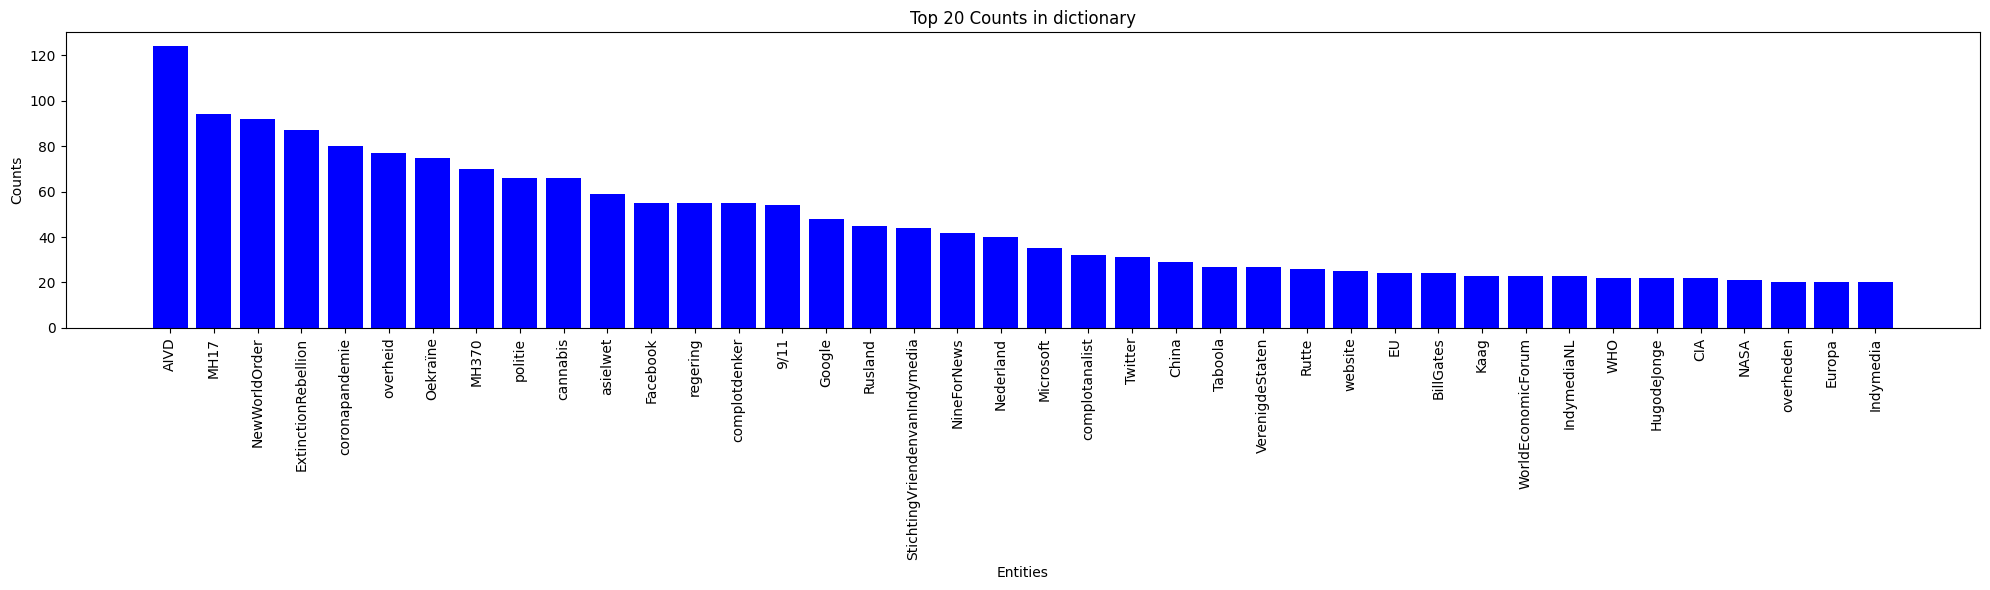

In [7]:
def plot_highest_counts(dictionary, top=20):
    '''
    Gives the top 20 counts of entities or subjects mentioned in the dictionary

    :param dictionary: a dictionary containing the counts of each entity/topic
    :return: plot of top {top} counts
    '''
    # Sort the dictionary's items
    sorted_items = sorted(dictionary.items(), key=lambda x: x[1], reverse=True)[:top]

    # Get the counts
    gpt_output = [item[0] for item in sorted_items]
    counts = [item[1] for item in sorted_items]

    plt.figure(figsize=(20, 6))
    plt.bar(range(len(gpt_output)), counts, align='center', color='blue')
    plt.xticks(range(len(gpt_output)), gpt_output, rotation='vertical')
    plt.xlabel('Entities')
    plt.ylabel('Counts')
    plt.title(f'Top 20 Counts in dictionary')
    plt.tight_layout()

    plt.show()

plot_highest_counts(entity_count_dict, top=40)

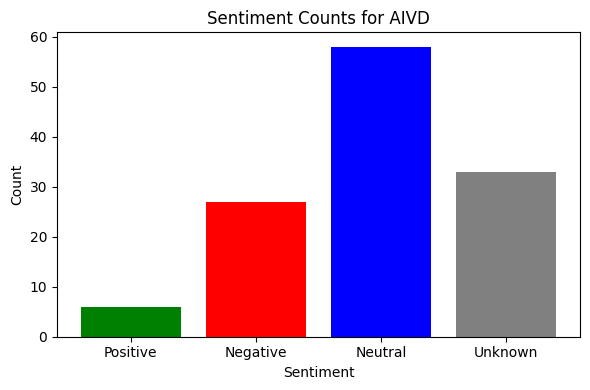

In [106]:
def plot_sentiment_for(df, target, entity=False, subject=False):
    '''
    Gives a bar plot for the sentiment

    :param df: the dataframe containing column 'GPT output'
    :param target: The entity/subject to plot
    :param entity: Bool which tells the func to look in the entity dict
    :param subject: Bool which tells the func to look in the dict list
    :return:
    '''
    positive = 0
    negative = 0
    neutral = 0
    unknown = 0

    if entity:
        for index, _ in enumerate(df['GPT output']):
            for entity, sentiment in df['GPT output'][index].get('entiteiten').items():
                if entity == target:
                    if sentiment == 'positief':
                        positive += 1
                    elif sentiment == 'negatief':
                        negative += 1
                    elif sentiment == 'neutraal':
                        neutral += 1
                    elif sentiment == 'neutral':
                        neutral += 1
                    elif sentiment == 'Neutral':
                        neutral += 1
                    elif sentiment == 'onbekend':
                        unknown += 1
                    elif sentiment == 'n.v.t.':
                        unknown += 1
                    elif sentiment == 'onduidelijk':
                        unknown += 1
                    elif sentiment == 'onzeker':
                        unknown += 1
                    else:
                        continue

    if subject:
        for index, _ in enumerate(df['GPT output']):
            for subject, sentiment in df['GPT output'][index].get('onderwerpen').items():
                if subject == target:
                    if sentiment == 'positief':
                        positive += 1
                    elif sentiment == 'negatief':
                        negative += 1
                    elif sentiment == 'neutraal':
                        neutral += 1
                    elif sentiment == 'neutral':
                        neutral += 1
                    elif sentiment == 'Neutral':
                        neutral += 1
                    elif sentiment == 'onbekend':
                        unknown += 1
                    elif sentiment == 'n.v.t.':
                        unknown += 1
                    elif sentiment == 'onduidelijk':
                        unknown += 1
                    elif sentiment == 'onzeker':
                        unknown += 1
                    else:
                        continue

    if subject is False and entity is False:
        messagebox.showerror('Error', 'Please select whether the search target is in the entity or subject dictionary.')

    sentiments = ['Positive', 'Negative', 'Neutral', 'Unknown']
    counts = [positive, negative, neutral, unknown]

    plt.figure(figsize=(6, 4))
    plt.bar(sentiments, counts, color=['green', 'red', 'blue', 'grey'])
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.title(f'Sentiment Counts for {target}')
    plt.tight_layout()

    # Display the plot
    plt.show()

plot_sentiment_for(df, 'AIVD', entity=True)

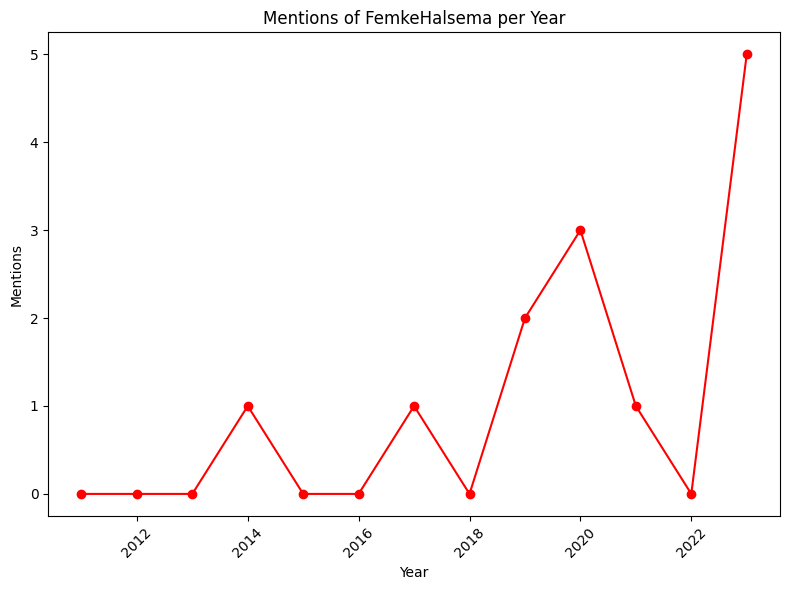

In [102]:
def plot_mentions_per_year(df, target, entity=False, subject=False):

    # Group the DataFrame by year and count the mentions for each entity or subject
    if entity:
        df['year'] = pd.to_datetime(df['date']).dt.year
        df_grouped = df.groupby('year')['GPT output'].apply(lambda x: x.str['entiteiten'].str.get(target).count())

    if subject:
        df['year'] = pd.to_datetime(df['date']).dt.year
        df_grouped = df.groupby('year')['GPT output'].apply(lambda x: x.str['onderwerpen'].str.get(target).count())

    if subject is False and entity is False:
        print('Please provide whether the search target is in the entity dict or the subject dict')

    # Create the line plot
    plt.figure(figsize=(8, 6))
    plt.plot(df_grouped.index, df_grouped.values, marker='o', linestyle='-', color='red')
    plt.xlabel('Year')
    plt.ylabel('Mentions')
    plt.title(f'Mentions of {target} per Year')
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Display the plot
    plt.show()

plot_mentions_per_year(df, 'FemkeHalsema', entity=True)

In [120]:
entity_count_dict = get_count_dicts(df)[0]
subject_count_dict = get_count_dicts(df)[1]

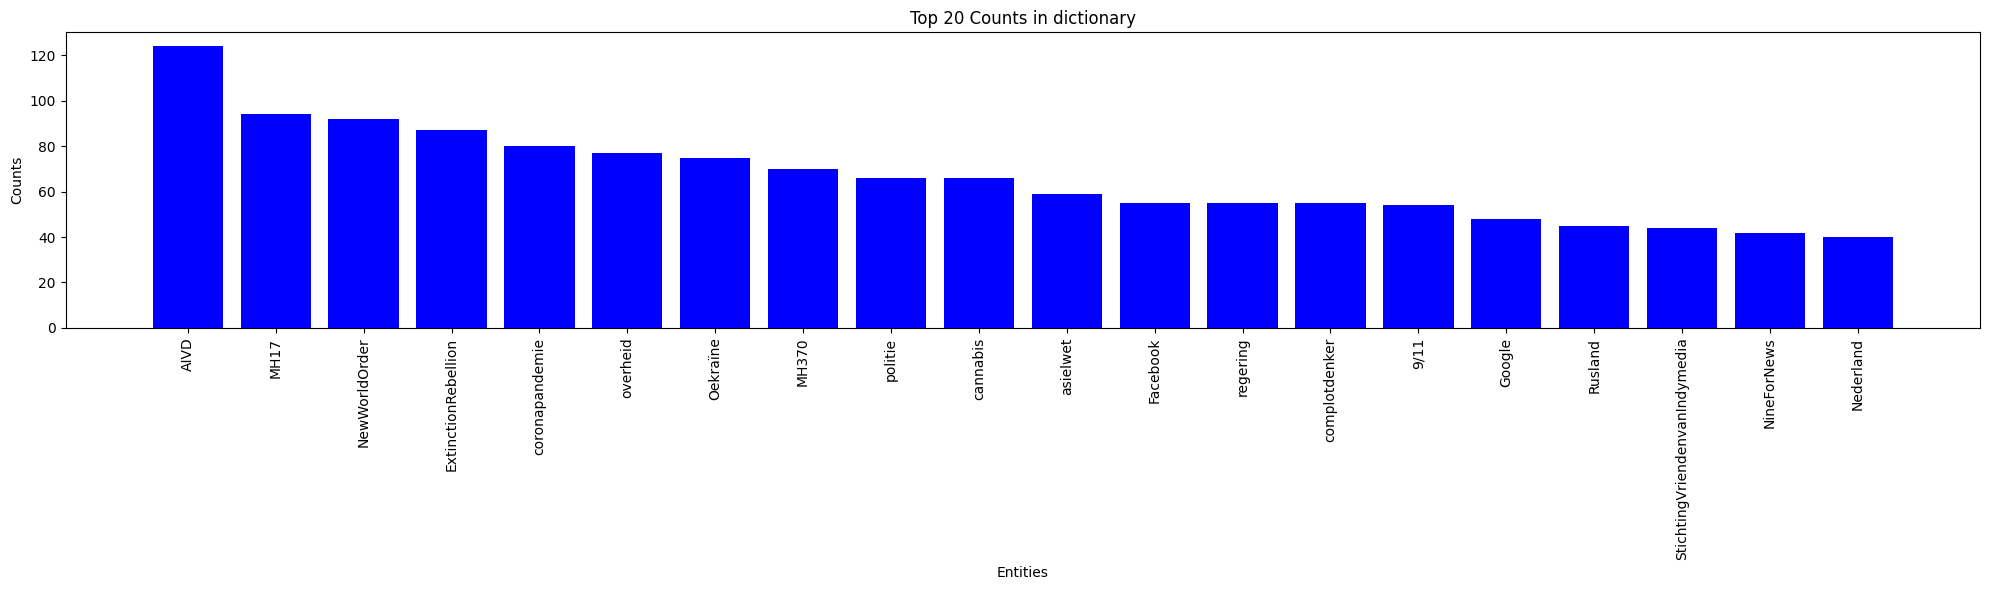

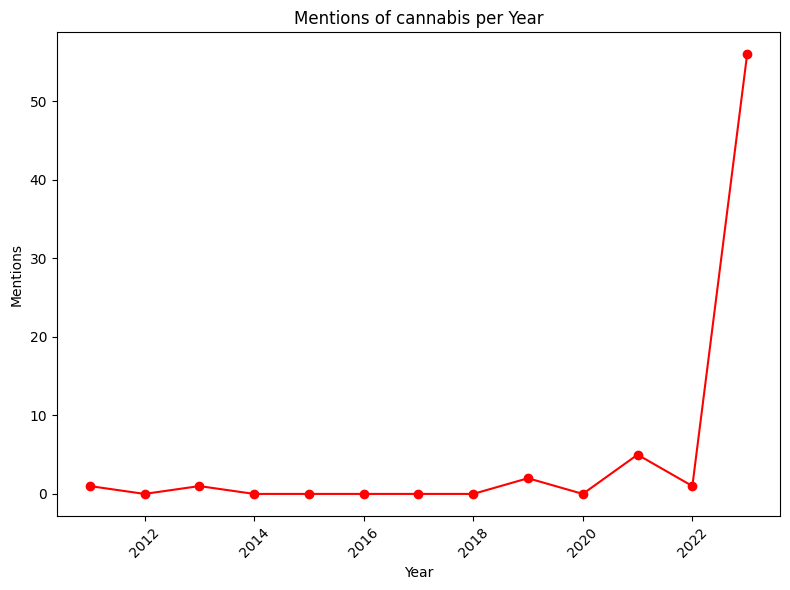

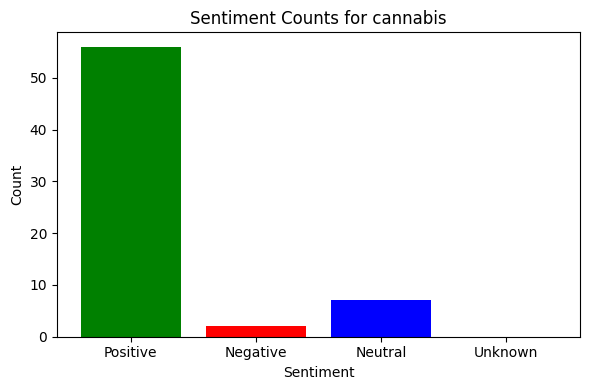

In [127]:
import tkinter as tk
from tkinter import messagebox

def plot_mentions_per_year(df, target, entity=False, subject=False):
    # Group the DataFrame by year and count the mentions for each entity or subject
    if entity:
        df['year'] = pd.to_datetime(df['date']).dt.year
        df_grouped = df.groupby('year')['GPT output'].apply(lambda x: x.str['entiteiten'].str.get(target).count())

    if subject:
        df['year'] = pd.to_datetime(df['date']).dt.year
        df_grouped = df.groupby('year')['GPT output'].apply(lambda x: x.str['onderwerpen'].str.get(target).count())

    if subject is False and entity is False:
        messagebox.showerror('Error', 'Please select whether the search target is in the entity or subject dictionary.')

    # Create the line plot
    plt.figure(figsize=(8, 6))
    plt.plot(df_grouped.index, df_grouped.values, marker='o', linestyle='-', color='red')
    plt.xlabel('Year')
    plt.ylabel('Mentions')
    plt.title(f'Mentions of {target} per Year')
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Display the plot
    plt.show()

def handle_plot_mentions_by_year_button():
    target = entry_target.get()
    if var_entity.get() == 1:
        plot_mentions_per_year(df, target, entity=True)
    elif var_subject.get() == 1:
        plot_mentions_per_year(df, target, subject=True)

def handle_plot_sentiment_button():
    target = entry_target.get()
    if var_entity.get() == 1:
        plot_sentiment_for(df, target, entity=True)
    elif var_subject.get() == 1:
        plot_sentiment_for(df, target, subject=True)

# def plot_highest_counts(dictionary, top=20):

def handle_plot_counts_button():
    top = entry_top.get()
    top = int(top)
    if var_entity_top.get() == 1:
        plot_highest_counts(entity_count_dict, top=top)
    elif var_subject_top.get() == 1:
        plot_highest_counts(subject_count_dict, top=top)

# Creating window
window = tk.Tk()
window.title("Plot selection GUI")
window.geometry("600x350")

# Create labels to create seperation in window
label_separation_1 = tk.Label(window, text="-------------------------------------------------------------------------------------------")
label_separation_1.pack()

label_text_2 = tk.Label(window, text="Use the setting below to specify the settings for total counts plot")
label_text_2.pack()

# Create a label for the entry top input
# Create a label for the target input
label_top = tk.Label(window, text="How many entities or subjects do you want to see?")
label_top.pack()

# Make entry field for top count
entry_top = tk.Entry(window)
entry_top.pack()

# Create a checkbox for entity
var_entity_top = tk.IntVar()
checkbox_entity_top = tk.Checkbutton(window, text="Entity", variable=var_entity_top)
checkbox_entity_top.pack()

# Create a checkbox for subject
var_subject_top = tk.IntVar()
checkbox_subject_top = tk.Checkbutton(window, text="Subject", variable=var_subject_top)
checkbox_subject_top.pack()

# Make button to plot top counts
button_plot_sentiment = tk.Button(window, text='Plot counts', command=handle_plot_counts_button)
button_plot_sentiment.pack()

# Create a seperation label
label_separation = tk.Label(window, text="-------------------------------------------------------------------------------------------")
label_separation.pack()

# Create a label which specifies options
label_text_1 = tk.Label(window, text="Use the setting below to specify settings for the mentions and sentiment plots")
label_text_1.pack()

# Create a label for the target input
label_target = tk.Label(window, text="Enter target entity or subject:")
label_target.pack()

# Create an entry field for the target input
entry_target = tk.Entry(window)
entry_target.pack()

# Create a checkbox for entity
var_entity = tk.IntVar()
checkbox_entity = tk.Checkbutton(window, text="Entity", variable=var_entity)
checkbox_entity.pack()

# Create a checkbox for subject
var_subject = tk.IntVar()
checkbox_subject = tk.Checkbutton(window, text="Subject", variable=var_subject)
checkbox_subject.pack()

# Create a button to plot the mentions per year
button_plot_mentions = tk.Button(window, text="Plot mentions by year", command=handle_plot_mentions_by_year_button)
button_plot_mentions.pack()

# Make button to plot sentiment
button_plot_sentiment = tk.Button(window, text='Plot sentiment', command=handle_plot_sentiment_button)
button_plot_sentiment.pack()



# Start the Tkinter event loop
window.mainloop()